# Pytorch 操作介紹: 一般自有資料操作流程
## 1. 單步解說: 以IRIS資料為例
## 2. 完整操作:以BOSTON房價為例

--------------------------
## 1. 單步解說: 以IRIS資料為例
I. dataloader<br>
II. 自建模型<br>
III. 損失/目標函數(loss函數)<br>
IV. 梯度更新<br>

### I. Dataloader
在今天課程，我們使用IRIS data當作私有資料範例，這邊我已經將iris.data改成csv資料格式(iris.csv)<br>
iris.csv存放路徑為: /dataset/iris.csv，我們用excel將檔案打開如下：<br>
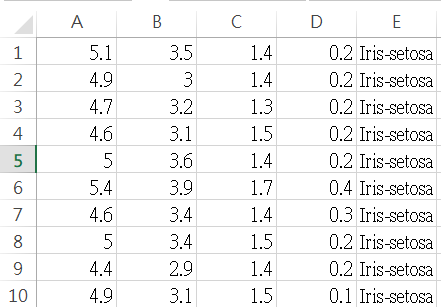

這邊我們使用numpy模組將csv讀到電腦內，但實際上不一定要用numpy，用你覺得方便的方法即可。<br>
因為此csv內有文字格式，所以我們用str方式進行存取<br>

In [1]:
import torch
import numpy as np
filepath = './Data/iris.csv'
csvdata_iris = np.loadtxt(filepath,dtype=np.str_, delimiter=',')
print(csvdata_iris[0:150:20,:])

[['5.1' '3.5' '1.4' '0.2' 'Iris-setosa']
 ['5.4' '3.4' '1.7' '0.2' 'Iris-setosa']
 ['5.0' '3.5' '1.3' '0.3' 'Iris-setosa']
 ['5.0' '2.0' '3.5' '1.0' 'Iris-versicolor']
 ['5.5' '2.4' '3.8' '1.1' 'Iris-versicolor']
 ['6.3' '3.3' '6.0' '2.5' 'Iris-virginica']
 ['6.9' '3.2' '5.7' '2.3' 'Iris-virginica']
 ['6.7' '3.1' '5.6' '2.4' 'Iris-virginica']]


<font size=4>利用PyTorch內建的函數進行資料打包和隨機切割batch(批次)資料
1. torch.utils.data.TensorDataset
2. torch.utils.data.DataLoader
</font>
    
#### 1. torch.utils.data.TensorDataset
- 1. 將numpy array轉換到Torch Tensor
- 2. 利用```torch.utils.data.TensorDataset``` 將資料打包

In [2]:
import torch
import numpy as np
filepath = './Data/iris.csv'
csvdata_iris = np.loadtxt(filepath,dtype=np.str_, delimiter=',')
X = np.float_(csvdata_iris[:,0:4])
Y = csvdata_iris[:,4]
label=[]
for tmp_y in Y:
    if tmp_y == 'Iris-setosa':
        label.append(0)
    elif tmp_y == 'Iris-versicolor':
        label.append(1)
    elif tmp_y == 'Iris-virginica':
        label.append(2)
Y=label

X_tensor = torch.tensor(X, dtype=torch.float) # X_train = torch.FloatTensor(X_train)
Y_tensor = torch.tensor(Y, dtype=torch.long)
print('X_tensor:{}'.format(X_tensor.shape))
print('Y_tensor:{}'.format(Y_tensor.shape))
mydatasets = torch.utils.data.TensorDataset(X_tensor, Y_tensor)

X_tensor:torch.Size([150, 4])
Y_tensor:torch.Size([150])


我們看一下利用torch.utils.data.TensorDataset將資料打包有什麼用?

In [3]:
for i, tmp  in enumerate(mydatasets):
    print('{}-th:{}'.format(i, tmp))
    if i==2:break
print('manually selection')
print('0-th:{}'.format(mydatasets[0]))    
print('1-th:{}'.format(mydatasets[1]))    
print('2-nd:{}'.format(mydatasets[2]))    

0-th:(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))
1-th:(tensor([4.9000, 3.0000, 1.4000, 0.2000]), tensor(0))
2-th:(tensor([4.7000, 3.2000, 1.3000, 0.2000]), tensor(0))
manually selection
0-th:(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))
1-th:(tensor([4.9000, 3.0000, 1.4000, 0.2000]), tensor(0))
2-nd:(tensor([4.7000, 3.2000, 1.3000, 0.2000]), tensor(0))


所以利用```torch.utils.data.TensorDataset```把包後的mydatasets會將資料依照訊續一筆一筆輸出。<br>
這樣如果我在訓練模型時候的資料，永遠都會依照順序輸出，一點好處都沒有啊，我們在訊練模型為了避免資料在每一次學習過程中都都是一樣的排列處和，我們會希望在每一次訓練資料都是隨機組成一個batch。<br>
ANS: Write the shuffle code by yourself, it's easy but "why do we not use a ready code?"<br>
using ```torch.utils.data.DataLoader```<br>
#### 2. torch.utils.data.DataLoader

In [4]:
mydataloader_noshu = torch.utils.data.DataLoader(mydatasets, batch_size=3, shuffle=False,num_workers=0)
mydataloader_shu = torch.utils.data.DataLoader(mydatasets, batch_size=3, shuffle=True,num_workers=0)

我們讓dataloader重覆跑三次，來看看每一次dataloder重新跑for loop取出來的資料有沒有一樣
1. 沒有Shuffle的dataloader

In [5]:
for i_repeat in range(3):
    for i, tmp  in enumerate(mydataloader_noshu):
        data  = tmp[0]
        print('{}-iter :\n{}-th data:\n{}'.format(i_repeat, i, data))
        if i==0:break 

0-iter :
0-th data:
tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000]])
1-iter :
0-th data:
tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000]])
2-iter :
0-th data:
tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000]])


2. 有Shuffle的dataloader

In [6]:
for i_repeat in range(3):
    for i, tmp  in enumerate(mydataloader_shu):
        data  = tmp[0]
        print('{}-iter :\n{}-th data:\n{}'.format(i_repeat, i, data))
        if i==0:break 

0-iter :
0-th data:
tensor([[5.4000, 3.4000, 1.7000, 0.2000],
        [6.1000, 2.9000, 4.7000, 1.4000],
        [6.3000, 2.5000, 5.0000, 1.9000]])
1-iter :
0-th data:
tensor([[5.0000, 3.0000, 1.6000, 0.2000],
        [6.1000, 3.0000, 4.6000, 1.4000],
        [5.9000, 3.2000, 4.8000, 1.8000]])
2-iter :
0-th data:
tensor([[6.0000, 2.9000, 4.5000, 1.5000],
        [4.8000, 3.1000, 1.6000, 0.2000],
        [6.1000, 2.6000, 5.6000, 1.4000]])


<font size=4> 如何操作自建立的dataset和dataloder的細節我們在下一堂「成為AI工程師必學的深度學習與 PyTorch 實作」中利用主題單元來詳述。

### II. 自建模型
利用PyTorch自建立模型
1. 簡易建立方式: 直接練一回歸模型→$y=f(w_0+w_1x_1+w_2x_2+w_3x_3+w_4x_4), y=0,1,2$
2. 正常建立方式: 建立MLP→$y=f(x), y=0,1,2$

In [7]:
model_simple = torch.nn.Sequential(
    torch.nn.Linear(4, 3)
)
print(model_simple)

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
)


這邊在宣告你要用什麼神經網路，自己兜得或是開源模型都可以

Multiple-layer perceptron (MLP)
這邊我們用一個一層Hidden layer<br>
所以神經網路的結構為<br>
Input layer (node數為4) → Hidden layer (node數設定為10) → Output layer (node數為3)
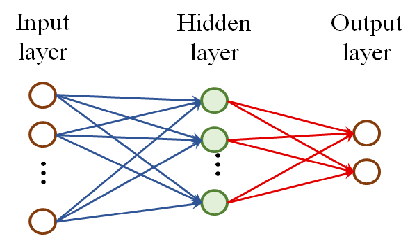

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, input_channel=4, n_class=3):
        super(MLP,self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_channel, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, n_class),
            )
    def forward(self,x):
        x = self.mlp(x)
        return x
model_mlp = MLP(input_channel=4, n_class=3)
print(model_mlp)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)


### III. 損失/目標函數(loss函數)

<br>宣告loss函數，模型預測的結果和ground truth整合計算差異用來更新模型</br>
<br>這邊提的是和ground truth整合計算差異所以泛屬於supervised learning</br>
<br>reference:https://pytorch.org/docs/stable/nn.html#loss-functions

<br>**這邊我們用到的是cross entropy作為loss function**
<br>torch.nn.CrossEntropyLoss = log_softmax → nll_loss 
<br>log_softmax: torch.nn.functional.log_softmax
<br>nll_loss: torch.nn.functional.nll_loss (negative log likelihood loss)

In [9]:
loss = torch.nn.CrossEntropyLoss()

import numpy as np
x = np.array([[3.0,2.0,1.0],
              [4.0,5.0,6.0]])
inputdata = torch.tensor(x, requires_grad=True)
target = np.array([0, 2])
target = torch.LongTensor(target)
output1 = loss(inputdata, target)
print('inputdata:{}'.format(inputdata))
print('target:{}'.format(target))
print('loss value by function (torch.nn.CrossEntropyLoss): {}'.format(output1))


from  torch.nn.functional import log_softmax,nll_loss, softmax
ls_x = log_softmax(inputdata,dim=1)
output2 = nll_loss(ls_x, target)
print('loss value by (log_softmax and nll_loss): {}'.format(output2))

inputdata:tensor([[3., 2., 1.],
        [4., 5., 6.]], dtype=torch.float64, requires_grad=True)
target:tensor([0, 2])
loss value by function (torch.nn.CrossEntropyLoss): 0.4076059644443804
loss value by (log_softmax and nll_loss): 0.4076059644443804


所以用程式算Cross entropy分別用這兩種方式計算
1. torch.nn.CrossEntropyLoss，結果為 0.4076059644443804
2. log_softmax → nll_loss，結果為 0.4076059644443804
結果是一樣的

所以用程式算Cross entropy分別用這兩種方式計算
<br> 1. torch.nn.CrossEntropyLoss，結果為 0.4076059644443804
<br> 2. log_softmax → nll_loss，結果為 0.4076059644443804
<br>結果是一樣的

<br>**利用手算**:  
<br>$ x = \begin{bmatrix} 3 & 2 & 1 \\ 4 & 5 & 6 \\ \end{bmatrix} $
$, label = \begin{bmatrix} 0 \\ 2 \\ \end{bmatrix} $
<br>Onehot encoder for label:
<br>$ y(label) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix} $

<br> softmax operator:
<br>$ p_i = softmax(x_i)= \frac{exp((x_i))}{\sum_{l=1}^L exp(x_i(l))}$

<br>$ p = \begin{bmatrix} p_1 \\ p_2 \\ \end{bmatrix} = \begin{bmatrix} 0.6652 & 0.2447 & 0.0900 \\ 0.0900 & 0.2447 & 0.6652 \\ \end{bmatrix}$

<br>$ log(p) = \begin{bmatrix} -0.4076 & -1.4076 & -2.4076 \\ -2.4076 & -1.4076 & -0.4076 \\ \end{bmatrix}$

$CE = -\sum_{i=1}^n \sum_{c=1}^L y_{i,c} * log(p_{i,c})$
<br>$ = -(1 \times -0.4076 + 0 \times -1.4076 + 0 \times-2.4076)  + (0 \times -2.4076 + 0 \times -1.4076 + 1 \times-0.4076) $
<br>$ = -(-0.4076 + -0.4076) $
<br>$ = 0.8152 $

<font color = red  size=4>**手算結果為0.8152怎麼跟程式 0.4076不一樣**</font>
<br><br> 我們看一下程式碼CrossEntropyLoss default參數
<br><br>   torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, <font color = red> **reduction='mean'**</font>)
<br><br> 程式碼用平均後的結果，所以手算的結果0.8152除上2，$ 0.8152 \div{2} =0.4076$ 就跟程式 0.4076的一樣了
<br><br> 這個範例是兩筆資料，假設我們有一千筆資料，每一筆資料的CE loss都是0.4076，如果我們不用平均的方式處理，CE=407.6，這樣的loss值太大，我們很難好好更新模型參數，所以採用平均數的做法有點類似正規化，避免整體loss因為樣本數過多爆掉。


### IV. 梯度更新
這邊細節我們不講，細節我們在下一堂「**成為AI工程師必學的深度學習與 PyTorch 實作**」中利用主題單元來詳述。<br>
我們直接採用Torch內的函數**最佳化器**```torch.optim```<br>
這個步驟是在看我們模型更新需要改用什麼樣的演算法<br>
例如: SGD, Adagrad, RMSprop, Adam, LBFGS等。<br>
reference: https://pytorch.org/docs/stable/optim.html<br>

因為神經網路是去更新模型的權重，可以想像是羅吉斯回歸的係數更新的概念(我們在羅吉斯回歸有提過，如果忘記可回去看一下羅吉斯回歸的內容)<br>
所以我們需要將模型的參數指定到最佳化器<br>
Example: ```optim.SGD(model.parameters(), lr=0.01)```

In [10]:
import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_simple = optim.SGD(model_simple.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)

#### 補上一個步驟0:要用CPU來計算還是GPU
運算的時候，CPU和GPU不能混再一起算。<br>
比如說 $y=wx$，$w$和$x$不能在不同設備<br>


|$w$|$x$|$wx$狀態|
|:-|:-|:-:|
|CPU|CPU|o|
|GPU|GPU|o|
|CPU|GPU|X|
|GPU|CPU|X|



In [23]:
import torch
use_cuda = 1
device_gpu = torch.device("cuda" )
device_cpu = torch.device("cpu")

print('-'*50)
w = torch.FloatTensor([10])
x = torch.FloatTensor([20])
print('x: {}, w:{}'.format(x.device,w.device))
print('x*w={}({})'.format(x*w,(x*w).device))
print('-'*50)
w = torch.FloatTensor([10]).to(device_gpu)
x = torch.FloatTensor([20]).to(device_gpu)
print('x: {}, w:{}'.format(x.device,w.device))
print('x({})*w({})={}({})'.format(x.device,w.device,x*w,(x*w).device))

print('-'*50)
w = torch.FloatTensor([10]).to(device_cpu)
x = torch.FloatTensor([20]).to(device_gpu)
print('x: {}, w:{}'.format(x.device,w.device))
print('x({})*w({})={}({})'.format(x.device,w.device,x*w,(x*w).device))

--------------------------------------------------
x: cpu, w:cpu
x*w=tensor([200.])(cpu)
--------------------------------------------------
x: cuda:0, w:cuda:0
x(cuda:0)*w(cuda:0)=tensor([200.], device='cuda:0')(cuda:0)
--------------------------------------------------
x: cuda:0, w:cpu


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

我個人覺得最好的方式是宣告一個device，不管是什麼要計算的，你都丟到你宣告的device就好，比較單純

### 模型開始訓練
0. 要用CPU來計算還是GPU: ```device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")```
1. Dataloader: ```mydataloader = torch.utils.data.DataLoader(mydatasets, batch_size=3, shuffle=True, num_workers=0)```
2. Model宣告: ```model_mlp```, ```model_simple```
3. 損失函數: ```loss = torch.nn.CrossEntropyLoss()```
4. 最佳化器: ```optimizer_simple```,```optimizer_mlp```

In [35]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

mydataloader = torch.utils.data.DataLoader(mydatasets, batch_size=50, shuffle=True, num_workers=0)

loss = torch.nn.CrossEntropyLoss().to(device)

model_mlp = MLP(input_channel=4, n_class=3).to(device)

optimizer_mlp = torch.optim.SGD(model_mlp.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.02)
n_epoch = 100
model_mlp.train()
model_simple.train()

for epoch in range(n_epoch):
    for batch_idx, (data, target) in enumerate(mydataloader_shu):
        data=data.to(device)
        target=target.to(device)

        output_mlp = model_mlp(data)
        loss_mlp = loss(output_mlp, target) # batch * n_class, target: batch    
        optimizer_mlp.zero_grad()
        loss_mlp.backward()
        optimizer_mlp.step()
        
    print('MLP Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
        epoch, 
        100. * batch_idx / len(mydataloader_shu), 
        loss_mlp.item())
         )
            

MLP Train Epoch:0 [98.0%]	Loss: 1.551965
MLP Train Epoch:1 [98.0%]	Loss: 1.039103
MLP Train Epoch:2 [98.0%]	Loss: 1.150785
MLP Train Epoch:3 [98.0%]	Loss: 1.182669
MLP Train Epoch:4 [98.0%]	Loss: 0.853995
MLP Train Epoch:5 [98.0%]	Loss: 0.753155
MLP Train Epoch:6 [98.0%]	Loss: 0.849270
MLP Train Epoch:7 [98.0%]	Loss: 1.042340
MLP Train Epoch:8 [98.0%]	Loss: 0.912241
MLP Train Epoch:9 [98.0%]	Loss: 0.785957
MLP Train Epoch:10 [98.0%]	Loss: 0.648916
MLP Train Epoch:11 [98.0%]	Loss: 0.760638
MLP Train Epoch:12 [98.0%]	Loss: 0.774778
MLP Train Epoch:13 [98.0%]	Loss: 0.816631
MLP Train Epoch:14 [98.0%]	Loss: 0.728308
MLP Train Epoch:15 [98.0%]	Loss: 0.773191
MLP Train Epoch:16 [98.0%]	Loss: 0.944721
MLP Train Epoch:17 [98.0%]	Loss: 0.826455
MLP Train Epoch:18 [98.0%]	Loss: 0.751935
MLP Train Epoch:19 [98.0%]	Loss: 0.663438
MLP Train Epoch:20 [98.0%]	Loss: 0.747121
MLP Train Epoch:21 [98.0%]	Loss: 0.771797
MLP Train Epoch:22 [98.0%]	Loss: 0.647370
MLP Train Epoch:23 [98.0%]	Loss: 0.636980
ML

## 2. 完整操作:以BOSTON房價為例

In [50]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms.functional as FT
from torchvision import transforms
import torch.nn as nn
import numpy as np

def load_boston_sklearn():
    X, Y = load_boston(return_X_y=True)
    for i in range(13):
        X[:,i]=(X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2022)
    return  X_train, X_test, Y_train, Y_test

use_cuda=0
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")


# Step 1: data loader
X_train, X_test, Y_train, Y_test = load_boston_sklearn()
X_train = torch.tensor(X_train, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float).view(-1, 1)
mydatasets_train = torch.utils.data.TensorDataset(X_train, Y_train)
mydatasets_test = torch.utils.data.TensorDataset(X_test, Y_test)
dataloader_train = torch.utils.data.DataLoader(mydatasets_train, batch_size=5, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(mydatasets_test, batch_size=5, shuffle=False)

# Step 2: model 
w_num = X_train.shape[1]
model_MLP = torch.nn.Sequential(
    torch.nn.Linear(w_num, w_num*2),
    torch.nn.Linear(w_num*2, w_num*4),
    torch.nn.Linear(w_num*4, 1),
)
model_LR = torch.nn.Sequential(
    torch.nn.Linear(w_num, 1)
)
model_MLP=model_MLP.to(device)
model_LR=model_LR.to(device)

# step 3: loss function
loss = torch.nn.MSELoss().to(device)
# step4. optimator
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)
optimizer_LR = torch.optim.Adam(model_LR.parameters(), lr=0.01)

# step 5. model training
n_epoch = 100
model_MLP.train()
model_LR.train()
train_loss_LR, train_loss_MLP = [],[]
performance_test=[]
for epoch in range(n_epoch):
    if epoch % 50 ==0:
        print('epoch:{}/{}'. format(epoch, n_epoch))
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        
        output_lr = model_LR(data)
        loss_lr = loss(output_lr,target) 
        optimizer_LR.zero_grad()
        loss_lr.backward()
        optimizer_LR.step()
        
        output_mlp = model_MLP(data)
        loss_mlp = loss(output_mlp,target) 
        optimizer_MLP.zero_grad()
        loss_mlp.backward()
        optimizer_MLP.step()
        
        train_loss_LR.append(loss_lr.cpu().detach().numpy())
        train_loss_MLP.append(loss_mlp.cpu().detach().numpy())
        
    # Test
    model_LR.eval()
    model_MLP.eval()
    test_loss_mlp,  test_loss_lr= 0, 0    
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
             # model_LR
            output_lr = model_LR(data)
            loss_lr = loss(output_lr, target) 
            test_loss_lr+=loss_lr
            # MLP
            output_mlp = model_MLP(data)
            loss_mlp = loss(output_mlp,target) 
            test_loss_mlp+=loss_mlp
    test_loss_lr/=len(dataloader_test)
    test_loss_mlp/=len(dataloader_test)
    performance_test.append([test_loss_lr, test_loss_mlp])       
print('training done.')



epoch:0/100
epoch:50/100
training done.


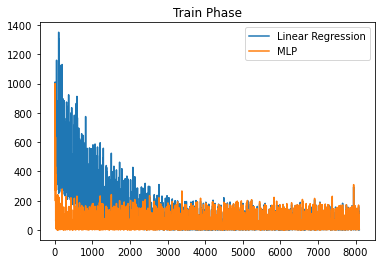

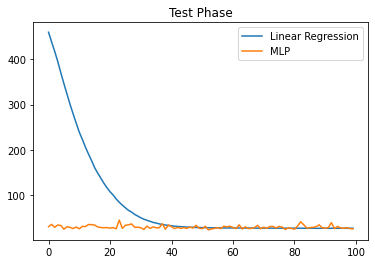

In [51]:
import matplotlib.pyplot as plt
plt.plot(train_loss_LR,label='Linear Regression')
plt.plot(train_loss_MLP,label='MLP')
plt.title('Train Phase')
plt.legend()
plt.show()

performance_test=np.array(performance_test)
plt.plot(performance_test[:,0],label='Linear Regression')
plt.plot(performance_test[:,1],label='MLP')
plt.title('Test Phase')
plt.legend()
plt.show()


Correlation between preds and gts (Torch):  0.8065631852939095
Correlation between preds and gts (Torch):  0.8068824166199429


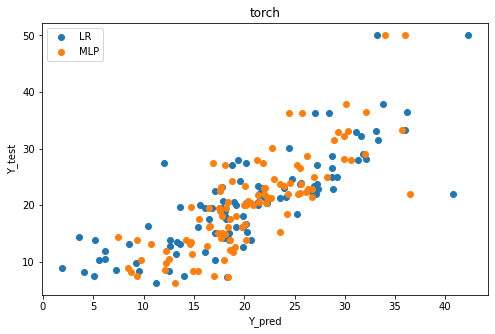

In [52]:
data = torch.FloatTensor(X_test).to(device)
data = torch.unsqueeze(data, 0)
model_LR.eval()
model_MLP.eval()
with torch.no_grad():
    output_lr = model_LR(data)
    output_mlp = model_MLP(data)

Y_test = torch.squeeze(Y_test)

output_lr = torch.squeeze(output_lr)
output_lr = output_lr.cpu().detach().numpy()
print('Correlation between preds and gts (Torch): ', np.corrcoef(output_lr, Y_test.cpu().detach().numpy())[0,1])

output_mlp = torch.squeeze(output_mlp)
output_mlp = output_mlp.cpu().detach().numpy()
print('Correlation between preds and gts (Torch): ', np.corrcoef(output_mlp, Y_test.cpu().detach().numpy())[0,1])

# whole plot size
plt.figure(figsize=(8, 5))
plt.scatter(output_lr, Y_test,label='LR')
plt.scatter(output_mlp, Y_test,label='MLP')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('torch')
plt.legend()
plt.show()

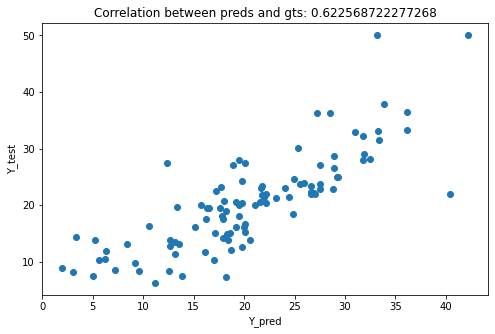

In [53]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
reg = LinearRegression()
reg.fit(X_train,Y_train)
# whole plot size
plt.figure(figsize=(8, 5))
Y_pred = reg.predict(X_test)
plt.scatter(Y_pred, Y_test)
plt.title('Correlation between preds and gts: {}'.format(reg.score(X_test, Y_test)))
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.show()

In [54]:
print('-'*50)
print('Weight in pytorch:\n{}'.format(model_LR[0].weight.detach().numpy()))
print('bias in pytorch:\n{}'.format(model_LR[0].bias.detach().numpy()))
print('-'*50)
print('Weight in sklearn:\n{}'.format(reg.coef_))
print('bias in sklearn:\n{}'.format(reg.intercept_))

--------------------------------------------------
Weight in pytorch:
[[-0.92126554  0.87442577  0.15514416  0.70873135 -1.5027224   3.388292
  -0.33601698 -3.0378006   2.052869   -1.4733106  -1.9063096   0.95932823
  -3.6742105 ]]
bias in pytorch:
[22.519491]
--------------------------------------------------
Weight in sklearn:
[[-0.93972385  0.972992    0.33738798  0.6990202  -1.5908797   3.3077586
  -0.33648655 -3.0191772   2.598061   -2.0816858  -1.9368783   0.9439242
  -3.717811  ]]
bias in sklearn:
[22.53343]
